In [139]:
import sys
sys.path.append('../')
from corona_nlp.indexing import PaperIndexer, all_dataset_sources
from corona_nlp.preprocessing import load_papers_with_text

from transformers import pipeline
import pprint
pprint = pprint.PrettyPrinter(indent=14)

In [202]:
all_dataset_sources[0]

PosixPath('../data/CORD-19-research-challenge/2020-03-13/biorxiv_medrxiv/biorxiv_medrxiv')

In [140]:
biomed = PaperIndexer(all_dataset_sources[0])
biomed

<PaperIndexer(biorxiv_medrxiv, papers=803)>

In [141]:
biomed_samples = biomed(samples=5, shuffle=True)
biomed_samples[0]['body_text'][0]

{'text': 'Coronavirus was a large virus family, which was known to cause common cold and serious illness such as Middle East respiratory syndrome (MERS) and severe acute respiratory syndrome (SARS). [1] [2] [3] [4] It was found that the 2019 novel coronavirus (2019-nCoV) was the cause of unexplained viral pneumonia in Wuhan, China in December 2019, and was recognized by the World Health Organization (WHO) on January 12, 2020. In the following month, 2019-nCoV was transmitted in Hubei Province, throughout China and even other countries, 5 causing 34,662 confirmed cases by February 8, 2020.',
 'cite_spans': [{'start': 189, 'end': 192, 'text': '[1]', 'ref_id': 'BIBREF0'},
  {'start': 193, 'end': 196, 'text': '[2]', 'ref_id': 'BIBREF1'},
  {'start': 197, 'end': 200, 'text': '[3]', 'ref_id': 'BIBREF2'},
  {'start': 201, 'end': 204, 'text': '[4]', 'ref_id': 'BIBREF3'},
  {'start': 532, 'end': 533, 'text': '5', 'ref_id': 'BIBREF4'}],
 'ref_spans': [],
 'section': 'Introduction'}

In [142]:
indices = list(range(1, biomed.num_papers))
papers_with_text = load_papers_with_text(covid=biomed,
                                         indices=indices,
                                         keys=('abstract', 'body_text'))

In [143]:
from corona_nlp.preprocessing import normalize_whitespace

texts = []
for paper in papers_with_text:
    for line in sorted(set(paper['texts'])):
        string = normalize_whitespace(line)
        if string:
            texts.append(string)
len(texts)

74

In [17]:
# load the summarizer.
summarizer = pipeline('summarization')

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


In [18]:
documents = "".join(papers_with_text[0]['texts'])
docs_summary = summarizer(documents, min_length=150, max_length=500)
pprint.pprint(docs_summary[0]['summary_text'])

('10% of respondents consumed products of wild animals in Wuhan, twice that '
 'reported in Shanghai. Public strongly supports the regulations on wet '
 'markets to control the outbreak. Shanghai started its seasonal closure of '
 'LPMs on Jan 25 this year. The Chinese Government further instituted '
 'nationwide bans on all forms of wild animal transactions on Jan 26. These '
 'regulations may accelerate the decrease in exposing behaviours to live '
 'animals. However, the COVID-19 epidemic occurred prior to the Chinese lunar '
 'new year, when the demand for live animals is generally high. To date there '
 'is no primary research to quantify public behavioural response and support '
 'in containment measures. We plan to conduct a second-round survey at the end '
 'of the outbreak to track the long-term changes. Our sample was consistent '
 'with characteristics of the general population in the two cities.')


In [146]:
paper_id = papers_with_text[1]['id']
biomed[paper_id]

'532dc582abd41e833303742ca40976db63fe6fc1'

In [147]:
from corona_nlp.tokenizer import SpacySentenceTokenizer
from sentence_transformers import SentenceTransformer

scibert_nli_model = "/home/ego/huggingface-models/scibert-nli/"
sentence_tokenizer = SentenceTransformer(scibert_nli_model)

In [148]:
spacy_tokenizer = SpacySentenceTokenizer()
sentences = []
for line in spacy_tokenizer.tokenize("".join(texts)):
    string = normalize_whitespace(line.text.strip())
    if string not in sentences:
        sentences.append(string)
len(sentences)

215

In [149]:
embeddings = sentence_tokenizer.encode(sentences)
embeddings[0].shape

(768,)

## Calculating K

> Let's calculate the distortion for a given cluster range: `[1: maxrange]` to find the best `K` to use for our sentences

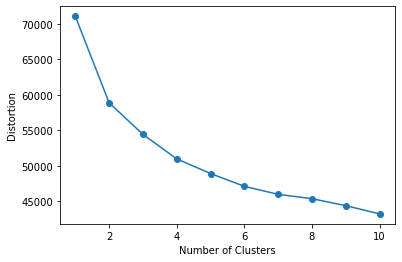

In [183]:
import matplotlib.pyplot as plt

n_pertub = 10
maxrange = 11
distortions = []
for i in range(1, maxrange):
    km = KMeans(n_clusters=i, init='random',
                n_init=n_pertub, max_iter=300,
                tol=1e-04, random_state=0)
    km.fit(embeddings)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.savefig('clusters-distortion.png')

In [162]:
from sklearn.cluster import KMeans
# from the graph above we can see that the 8th cluster will work
# the lower and steeper the drop == the worst!

n_clusters = 8
kmeans = KMeans(n_clusters, random_state=0).fit(embeddings)

In [169]:
def predict_cluster(sequence: str):
    """Predict cluster given a string sequence."""
    embedding = sentence_tokenizer.encode([sequence])
    return kmeans.predict(embedding)[0]

one_sentence = sentences[0]
pred_cluster = predict_cluster(one_sentence) + 1
print(f"predicted-cluster: {pred_cluster}")
print(f"sentence: {one_sentence}")

predicted-cluster: 4
sentence: In our survey, more than 20% of respondents visited wet markets at usual, which was similar in Wuhan and Shanghai, despite Shanghai being much more developed.


In [168]:
cluster_indices = [[] for i in range(n_clusters)]
for sentence_id, cluster_id in enumerate(kmeans.labels_):
    cluster_indices[cluster_id].append(sentences[sentence_id])

cluster_id = 4
cluster_indices[cluster_id - 1]

['In our survey, more than 20% of respondents visited wet markets at usual, which was similar in Wuhan and Shanghai, despite Shanghai being much more developed.',
 'Compared with the 30% level reported in 2013 in the same study sites, 15 the share of respondents visiting wet markets declined by 10 percentage points, but was still high.',
 '10% of respondents consumed products of wild animals in Wuhan, twice that reported in Shanghai.',
 'medRxiv preprint Shanghai started its seasonal closure of LPMs on Jan 25 this year.',
 'A population-based cross-sectional telephone survey via random dialing was conducted in Wuhan (the epicentre) and Shanghai (an affected city with imported cases) between 1 and 10 February, 2020.',
 '510 residents in Wuhan and 501 residents in Shanghai were randomly sampled.',
 'Respondents in Wuhan and Shanghai were generally similar in terms of sex, marital status and occupation, but in Shanghai respondents tended to be older and had higher education and income lev

> Here we can see how cluster `1` and `5` are clusters with noisy sentences, thanks kmeans

- Cluster `5`

```
 'https://doi.org/10.1101/2020.02.21.20026146 doi:',
 'medRxiv preprint employment status, were collected in our survey.',
 'medRxiv preprint Notes:',
 'p value is shown between Wuhan and Shanghai.',
 'medRxiv preprint 5 to reduce human transmission.',
 'medRxiv preprint have therapeutic effects.',
 'medRxiv preprint 4Word count (main text): 3489 :',
```

- Cluster `1`

```
 'https://doi.org/10.1101/2020.02.',
 '21.20026146 doi:',
 '28',
 '23',
 'All rights reserved.',
 'Our study has several limitations.',
 'First, there may be recall bias.',
 '[15]',
 'Notes:',
 '[22]',
 '22',
 '3(5.2)',
 '[3]',
```

* **Next remove clusters `1 and 5` and then summerize each cluster with transformers summerizer!**

In [176]:
cluster_indices[5]

['the author/funder, who has granted medRxiv a license to display the preprint in perpetuity.',
 '"2019 nCoV" or "COVID-19".',
 'https://doi.org/10.1101/2020.02.21.20026146 doi:',
 'medRxiv preprint employment status, were collected in our survey.',
 'medRxiv preprint Notes:',
 'p value is shown between Wuhan and Shanghai.',
 'medRxiv preprint 5 to reduce human transmission.',
 'medRxiv preprint have therapeutic effects.',
 'medRxiv preprint 4Word count (main text): 3489 :',
 'medRxiv preprintAll rights reserved.',
 '21.20026146 doi: medRxiv preprint containment measures.',
 'Multivariate logistic regression was used to estimate factors associated with public support for containment measures and confidence in intervention effectiveness.',
 'medRxiv preprint Wholesale Market.',
 'medRxiv preprint WHO stands for World Health Organization; PHEIC stands for public health emergency of international concern.',
 "P value are from Chi square test or fisher's exact tests (when applicable).(1,01

In [184]:
cluster_indices[1]

['No reuse allowed without permission.',
 'https://doi.org/10.1101/2020.02.',
 '21.20026146 doi:',
 '28',
 '23',
 'All rights reserved.',
 'Our study has several limitations.',
 'First, there may be recall bias.',
 '[15]',
 'Proportions are shown, and error bars represent 95% CIs.',
 'Notes:',
 '[22]',
 '22',
 '3(5.2)',
 '[1]',
 '[2]',
 '[3]',
 '[4]',
 '6',
 '7',
 '8',
 '[9]',
 '[10]',
 '[11]',
 '[12] [13]',
 '18',
 'The proportion and Odds Ratio with 95% confidence intervals (CI) were reported.',
 '10, 15',
 'All data are n (%).',
 '(Appendix Figure 1 )',
 '.(102/501)',
 'in Shanghai.',
 '[25]',
 '27',
 'Significance level:',
 '*',
 '* p<0.01,',
 'Exposure to All rights reserved.',
 '15',
 'Most All rights reserved.',
 '79.0%In']

In [212]:
def summarize_cluster(cluster_id: int, min_length=150, max_length=900):
    cluster = "".join(cluster_indices[cluster_id]) 
    summary = summarizer(cluster, min_length=min_length, max_length=max_length) 
    return summary[0]["summary_text"] 

cluster0_summary = summarize_cluster(0)
pprint.pprint(cluster0_summary)

('a ban on the wild animal trade, and 3) the quarantining of Wuhan. '
 'respondents were also asked to report the extent of their confidence in the '
 'effectiveness of these measures to quell the outbreak. The less educated and '
 'those exposing to live animals at usual were less likely to support '
 'containment measures. The Chinese Government further instituted nationwide '
 'bans on all forms of wild animal transactions on Jan 26. To date there is no '
 'primary research to quantify public behavioural response and support in '
 'containment measures in response to the outbreak, authors say. Evidence is '
 'urgently needed to help policy makers understand public response to outbreak '
 'and support for the containment measures, but no evidence is available to '
 'date, they say. The authors conclude that live animal transactions should be '
 'more strictly regulated, and wild animal Transactions should be even '
 'prohibited in the long term.')


In [213]:
cluster1_summary = summarize_cluster(1)
pprint.pprint(cluster1_summary)

('We aimed to identify behavioral changes in a cross-sectional survey, and '
 'outcomes before the outbreak were measured based on participant recall. '
 'Differences of outcome measures were compared before and during the '
 'outbreak, and between two cities. Our target population was persons aged 18 '
 'or over who had been living in the selected city for at least 6 months in '
 'the year prior to the survey and were current residents at the time of the '
 'survey. The anonymous phone interview addressed the concern of response bias '
 'due to fear of being seen as criticizing the government. We plan to conduct '
 'a second-round survey at the end of the outbreak to track the long-term '
 'changes. We also seek to understand levels of public support for containment '
 'measures and public confidence in their effectiveness to quell the outbreak.')


In [214]:
cluster2_summary = summarize_cluster(2)
pprint.pprint(cluster2_summary)

('10% of respondents consumed products of wild animals in Wuhan, twice that '
 'reported in Shanghai. In our survey, more than 20% of Respondents visited '
 'wet markets at usual, which was similar inWuhan and Shanghai, despite '
 'Shanghai being much more developed. As of Feb 16, 2020, a total of 70,548 '
 'cases have been reported in mainland China, with 1,770 resulting deaths. The '
 'outbreak has now spread beyond China to twenty-five other countries. The '
 'research has received funding from Sanofi Pasteur, and the copyright holder '
 'for this preprint (which was not peer-reviewed) is Wuhans. We found that '
 'population exposures to live animals were similar before the outbreak except '
 'that wild animal consumption was more prevalent in W Uhan.')


In [215]:
cluster3_summary = summarize_cluster(3)
pprint.pprint(cluster3_summary)

('In China, there exists a long tradition of eating the meat and products of '
 'wild animals. This persists into modern times due to a false but commonly '
 'held belief that these products are dangerous. China has issued strict '
 'regulations on wet markets where live and/or wild animals are traded, '
 'including closing live poultry markets (LPMs) and bans on wild animal '
 'transactions. The public responded quickly to this outbreak, and '
 'significantly reduced their exposure to live animals and stopped wild animal '
 'consumption, especially in Wuhan. With the currently high public support, '
 'bans on the wild animal trade should be promoted, but the government must be '
 'aware of the risk of creating an unregulated black market by instituting a '
 'ban. The above measures should be given priority in China and other '
 'countries to reduce current levels of COVID-19.')


In [216]:
cluster4_summary = summarize_cluster(4)
pprint.pprint(cluster4_summary)

('Wuhan is the site of origin of the COVID-19 outbreak.Shanghai was selected '
 'due to its status as a city that has been significantly affected. The '
 'practice of consuming wild animal products in China dates back to '
 'prehistoric times. The revival of this tradition may have set the '
 'socio-biological context for the occurrence and spread of CO VID-19 in '
 'China. We provide an assessment of behavioural change on exposure to live '
 'animals during the outbreak, by comparison before andDuring the outbreak. '
 'The study was approved by the Institutional Review Board of the School of '
 'Public Health, Fudan University (IRB#2020-TYSQ-01-1). The Chinese government '
 'introduced a series of All rights reserved. The author/funder has granted '
 'medRxiv a license to display the preprint in perpetuity.')


In [217]:
cluster5_summary = summarize_cluster(5)
pprint.pprint(cluster5_summary)

('The Chinese government has introduced a series of strict containment '
 'measures. With high public support in containment measures, better '
 'regulation of wet markets and healthy diets should be promoted. There was '
 'evidence that females were more supportive towards all three containment '
 'measures and that there was a positive association between education level '
 'and the likelihood of supporting regulations on wet markets. They were very '
 'supportive and confident for All rights reserved. For confidential support '
 'call the Samaritans in the UK on 08457 90 90 90, visit a local Samaritans '
 'branch or see www.samaritans.org for details. In the U.S. call the National '
 'Suicide Prevention Line on 1-800-273-8255 or visit '
 'www.suicidepreventionlifeline.org. For more information on how to help in '
 'China, click here.')
